[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)

# Isotopic relaxation (e-folding) timescales comparison 
1. Comparison for different environment settings.
2. Equations for timescales from:
- [Bolin 1958 (Proc. 2nd UN Intl Conf. Peaceful Uses of Atomic Energy)](https://digitallibrary.un.org/record/3892725),
- [Gedzelman & Arnold 1994 (J. Geophys. Res. Atmos. 99)](https://doi.org/10.1029/93JD03518), 
- [Miyake et al. 1968 (Pap. Meteorol. Geophys. 19)](https://doi.org/10.2467/mripapers1950.19.2_243),
- [Jouzel et al. 1975 (J. Geophys. Res. 80)](https://doi.org/10.1029/JC080i036p05015) 


compared with derived formula from Fick's an Fourier laws.






In [1]:
import sys
if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab("PySDM-examples")

In [2]:
import numpy as np
from matplotlib import pyplot
from functools import partial
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.physics.constants import PER_MILLE, PER_CENT

In [3]:
formulae = Formulae(
    terminal_velocity="RogersYau",
    particle_shape_and_density="LiquidSpheres",
    ventilation="PruppacherAndRasmussen1979",
    isotope_equilibrium_fractionation_factors="VanHook1968",
    isotope_diffusivity_ratios="HellmannAndHarvey2020+GrahamsLaw",
    isotope_relaxation_timescale="ZabaEtAl",
)
CONST = formulae.constants
T_10C = formulae.trivia.C2K(10)

In [4]:
isotopes = ("2H", "18O", "17O", "3H")
isotopes_attr = {
    isotope: {
        "alpha": getattr(
            formulae.isotope_equilibrium_fractionation_factors, f"alpha_l_{isotope}"
        ),
        "D_ratio_heavy_to_light": getattr(
            formulae.isotope_diffusivity_ratios, f"ratio_{isotope}_heavy_to_light"
        ),
        "VSMOW": getattr(CONST, f"VSMOW_R_{isotope}"),
        "latex_label": f"$^{{{{{''.join(filter(str.isdigit, isotope))}}}}}{''.join(filter(str.isalpha, isotope))}$"
    }
    for isotope in isotopes
}

In [5]:
pressure = CONST.p_STP
temperature = T_10C
D_light = formulae.diffusion_thermics.D(temperature, pressure)
rho_s = (
    formulae.saturation_vapour_pressure.pvs_water(temperature) / CONST.Rv / temperature
)


def vent_coeff(r, T, p):
    eta_air = formulae.air_dynamic_viscosity.eta_air(T)
    air_density = p / CONST.Rd / T
    Sc = formulae.trivia.air_schmidt_number(
        dynamic_viscosity=eta_air,
        diffusivity=D_light,
        density=air_density,
    )
    Re = formulae.particle_shape_and_density.reynolds_number(
        radius=r,
        velocity_wrt_air=formulae.terminal_velocity.v_term(r),
        dynamic_viscosity=eta_air,
        density=air_density,
    )
    return formulae.ventilation.ventilation_coefficient(
        formulae.trivia.sqrt_re_times_cbrt_sc(Re, Sc)
    )

tau_fun = partial(
    formulae.isotope_relaxation_timescale.tau,
    rho_s=rho_s,
    Fk=formulae.drop_growth.Fk(
        temperature,
        K=formulae.diffusion_thermics.K(temperature, pressure),
        lv=formulae.latent_heat_vapourisation.lv(temperature),
    ),
)

## Comparison for different environment settings

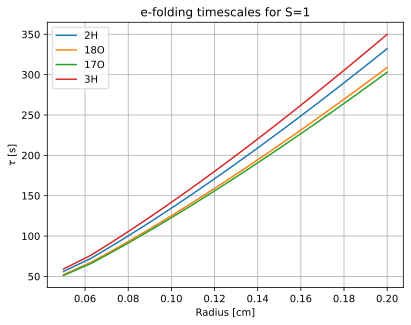

In [6]:
saturation = 1

radii = np.linspace(0.05, 0.2) * si.cm
temperature = T_10C

for isotope in isotopes:
    R_vap = isotopes_attr[isotope]["VSMOW"] * 3
    alpha = isotopes_attr[isotope]["alpha"](temperature)
    R_liq = 0.4 * R_vap * alpha
    D = D_light * vent_coeff(r=radii, T=temperature, p=pressure)
    pyplot.plot(
        in_unit(radii, si.cm),
        tau_fun(
            alpha=alpha,
            D_iso=np.asarray(isotopes_attr[isotope]["D_ratio_heavy_to_light"](
                temperature
            )) * D,
            D=D,
            radius=radii,
            S=saturation,
            R_vap=R_vap,
            R_liq=R_liq,
        ),
        label=isotope,
    )
pyplot.title(f"e-folding timescales for S={saturation:.3g}")
pyplot.gca().set(
    xlabel="Radius [cm]",
    ylabel="$\\tau$ [s]",
)
pyplot.legend()
pyplot.grid()
show_plot("fig_isotopes")

# Timescales comparison


In [7]:
radii = np.asarray((0.01, 0.05, 0.1, 0.2)) * si.cm

isotope = "18O"
alpha = isotopes_attr[isotope]["alpha"](temperature)
VSMOW = isotopes_attr[isotope]["VSMOW"]
R_liq = 100 * VSMOW * alpha

tau_max = 5000 * si.s

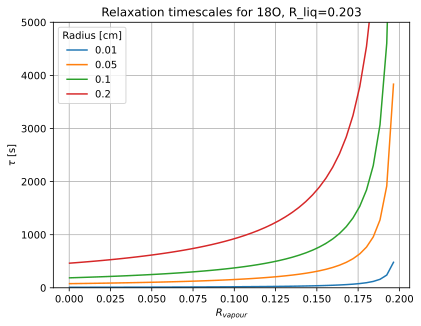

In [8]:
saturation = 1
R_vapour = np.linspace(VSMOW / 10, 100 * VSMOW)

for radius in radii:
    f = vent_coeff(r=radius, T=temperature, p=pressure)
    D = D_light * f
    tau = abs(formulae.isotope_relaxation_timescale.tau(
        alpha=alpha,
        D_iso=np.asarray(isotopes_attr[isotope]["D_ratio_heavy_to_light"](
            temperature
        )) * D,
        D=D,
        radius=radius,
        S=saturation,
        R_vap=R_vapour,
        R_liq=R_liq,
    ))
    pyplot.plot(R_vapour, tau, label=in_unit(radius, si.cm))
pyplot.gca().set(
    title=f"Relaxation timescales for {isotope}, {R_liq=:.3g}",
    xlabel="$R_{vapour}$",
    ylabel="$\\tau$ [s]",
    ylim=(0, tau_max),
)

pyplot.legend(title="Radius [cm]")
pyplot.grid()
plot_R_vap = pyplot.gcf()
show_plot("fig_vapour")

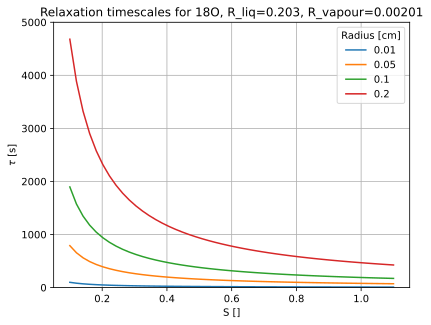

In [9]:
R_vapour = VSMOW
saturation = np.linspace(0.1, 1.1)

plots_S = []
for radius in radii:
    f = vent_coeff(r=radius, T=temperature, p=pressure)
    D = D_light * f
    pyplot.plot(
        saturation,
        np.abs(
            tau_fun(
                alpha=alpha,
                D_iso=np.asarray(isotopes_attr[isotope]["D_ratio_heavy_to_light"](
                    temperature
                )) * D,
                D=D,
                radius=radius,
                S=saturation,
                R_vap=R_vapour,
                R_liq=R_liq,
            )
        ),
        label=in_unit(radius, si.cm),
    )
pyplot.gca().set(
    title=f"Relaxation timescales for {isotope}, {R_liq=:.3g}, {R_vapour=:.3g}",
    xlabel="S []",
    ylabel="$\\tau$ [s]",
    ylim=(0 * si.s, tau_max)
)
pyplot.legend(title="Radius [cm]")
pyplot.grid()
plot_S = pyplot.gca()
show_plot("fig_saturation")

In [10]:
def my_label(factor, isotope_name):
    return f"{factor} {isotope_name}"

In [11]:
N = 50
isotopes_attr["2H"]["deltas_liq"] = np.linspace(-60.0, 40.0, N) * PER_MILLE
isotopes_attr["18O"]["deltas_liq"] = np.linspace(-20, 20, N) * PER_MILLE
isotopes_attr["3H"]["deltas_liq"] = np.linspace(-10, 1000, N) * PER_MILLE

In [12]:
bolins_table = (
    (0, 0.005, 3.3, 0.27, 0.9),
    (1, 0.01, 7.1, 0.72, 5.1),
    (2, 0.025, 33, 2.1, 69),
    (3, 0.05, 93, 4.0, 370),
    (4, 0.075, 165, 5.4, 890),
    (5, 0.1, 245, 6.5, 1600),
    (6, 0.15, 365, 8.1, 3000),
    (7, 0.2, 435, 8.8, 3800),
)

In [13]:
bolin = (0.1 * si.mm, 7.1 * si.s)

temperature = T_10C
radius = bolin[0]
saturation = np.linspace(0, 1, N)
f = vent_coeff(r=radius, T=temperature, p=pressure)
isotopes = ("3H", "2H", "18O")

R_vapour_factors = (0.6, 0.88, 0.925, 0.98, 1, 1.5)
tau = {}
dR_dt = {}
for isotope in isotopes:
    VSMOW = isotopes_attr[isotope]["VSMOW"]
    delta, S = np.meshgrid(isotopes_attr[isotope]["deltas_liq"], saturation)
    R_liq = formulae.trivia.isotopic_delta_2_ratio(delta, VSMOW)
    for R_vapour_factor in R_vapour_factors:
        D = D_light * f
        D_iso = np.asarray(isotopes_attr[isotope]["D_ratio_heavy_to_light"](temperature)) * D
        tau[my_label(R_vapour_factor, isotope)] = (
            formulae.isotope_relaxation_timescale.tau(
                rho_s=formulae.saturation_vapour_pressure.pvs_water(temperature)
                / CONST.Rv
                / temperature,
                alpha=isotopes_attr[isotope]["alpha"](temperature),
                D_iso=D_iso,
                D=D,
                radius=radius,
                S=S,
                R_vap=R_vapour_factor * VSMOW,
                R_liq=R_liq,
                Fk=formulae.drop_growth.Fk(
                    temperature,
                    K=formulae.diffusion_thermics.K(temperature, pressure),
                    lv=formulae.latent_heat_vapourisation.lv(temperature),
                )
            )
        )

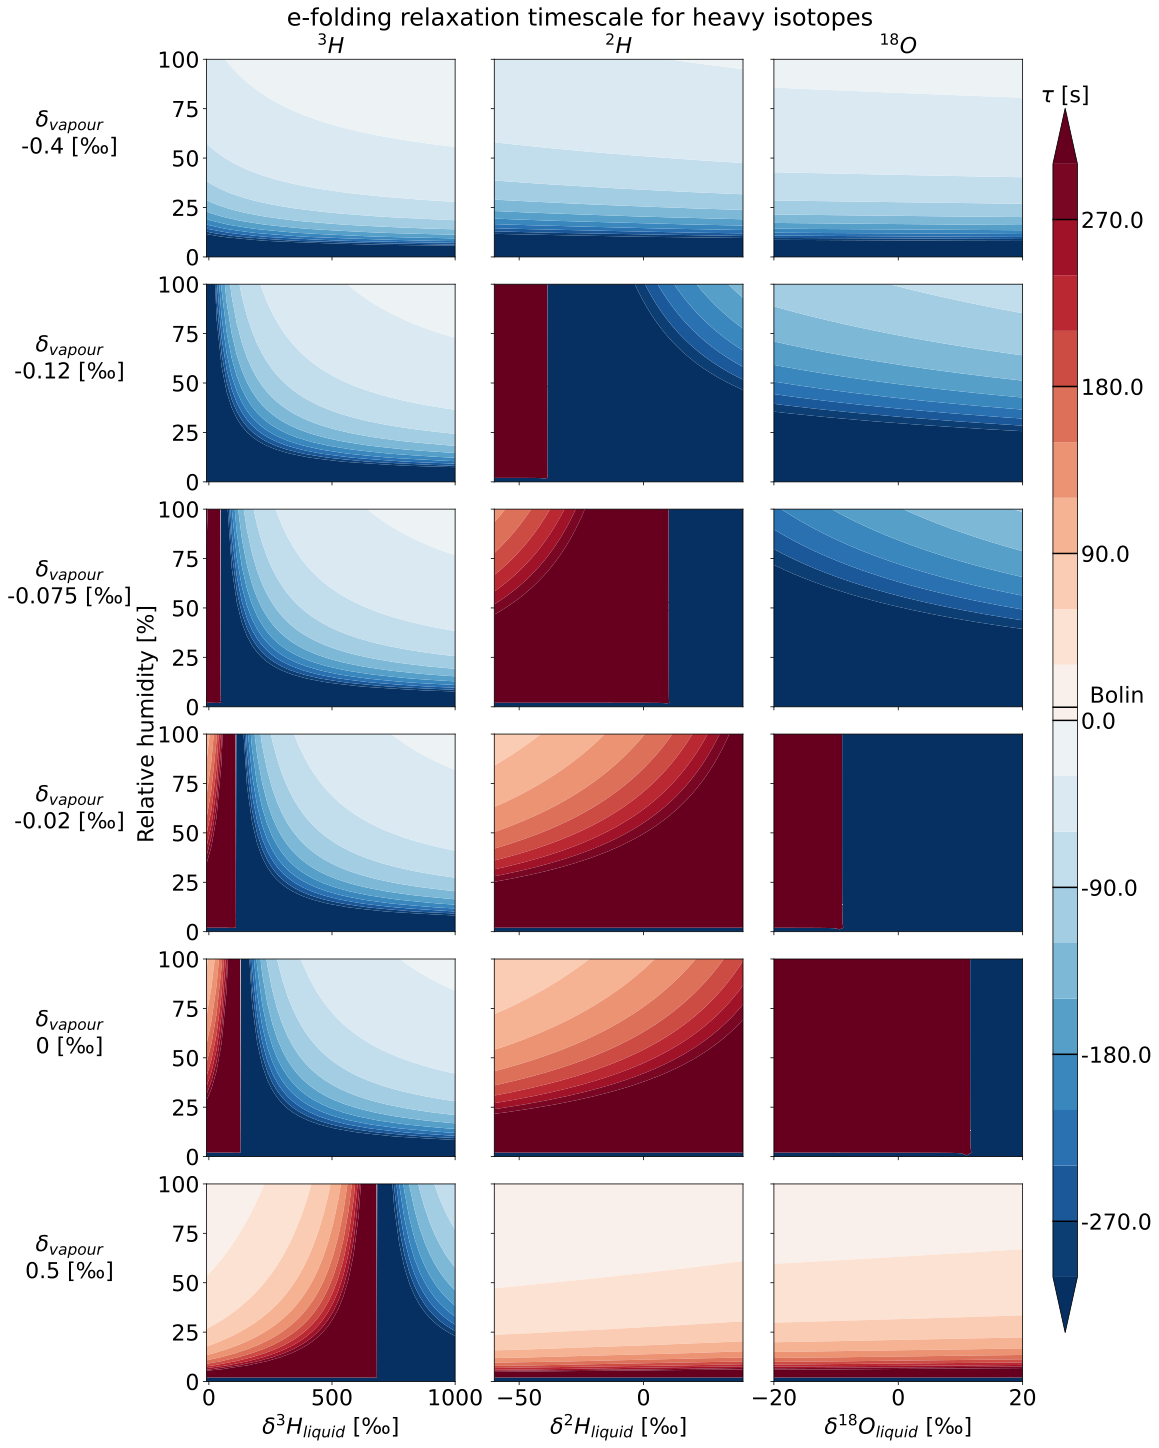

In [14]:
fontsize = 22
pyplot.rcParams.update(
    {"font.size": fontsize, "axes.labelsize": fontsize, "axes.titlesize": fontsize}
)
mosaic = [[my_label(R_vapour_factor, isotope) for isotope in isotopes] for R_vapour_factor in R_vapour_factors]
value = 300

fig = pyplot.figure(figsize=(16, 20), constrained_layout=True)
axs = fig.subplot_mosaic(mosaic, sharey=True)

axs_cols = [
    [axs[mosaic[i][j]] for i, _ in enumerate(R_vapour_factors)] for j, _ in enumerate(isotopes)
]
cmap = "RdBu_r"

for row_idx, row in enumerate(mosaic):
    for i, label in enumerate(row):
        delta, S = np.meshgrid(isotopes_attr[isotopes[i]]["deltas_liq"], saturation)
        pcm = axs[label].contourf(
            in_unit(delta, PER_MILLE),
            in_unit(S, PER_CENT),
            tau[label] * si.s,
            levels=np.linspace(-value, value, 21),
            cmap="RdBu_r",
            extend="both",
        )
        if row_idx != len(R_vapour_factors) - 1:
            axs[label].tick_params("x", labelbottom=False)
for isotope in isotopes:
    axs[my_label(R_vapour_factors[0], isotope)].set_title(isotopes_attr[isotope]['latex_label'])
    for R_vapour_factor in R_vapour_factors:
        axs[my_label(R_vapour_factor, isotope)].sharex(axs[my_label(R_vapour_factors[0], isotope)])
    axs[my_label(R_vapour_factors[-1], isotope)].set_xlabel(
        f"$\\delta${isotopes_attr[isotope]['latex_label']}$_{{liquid}}$ [‰]"
    )
for R_vapour_factor in R_vapour_factors:
    axs[my_label(R_vapour_factor, isotopes[0])].set_ylabel(
        f"$\\delta_{{vapour}}$\n{R_vapour_factor-1:.3g} [‰]", rotation="horizontal", labelpad=88
    )


fig.suptitle("e-folding relaxation timescale for heavy isotopes", fontsize=fontsize + 2)
fig.supylabel("Relative humidity [%]", x=0.115, fontsize=fontsize)


cb = fig.colorbar(
    pcm, ax=list(axs.values()), location="right", pad=0.02, fraction=0.03, aspect=50
)
ticks = cb.get_ticks()
cb.set_ticks(np.append(ticks, bolin[1]))
cb.ax.set_yticklabels(np.append(ticks, ""))
cb.ax.yaxis.set_tick_params(length=10, width=2)
cb.ax.tick_params(direction="in", length=25, width=1.5, right=True, left=False)
cb.ax.set_title("$\\tau$ [s]")

cb.ax.text(
    1.5,
    bolin[1],
    "Bolin",
    va="bottom",
    ha="left",
    transform=cb.ax.get_yaxis_transform(),
)

show_plot("comparison")